In [162]:
import numpy as np
from ampligraph.datasets import load_wn18
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.evaluation import mrr_score, hits_at_n_score
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
import tensorflow as tf
from ampligraph.evaluation import train_test_split_no_unseen 
import pandas as pd
import rdflib
import re

In [163]:
# load csv medsur.csv
colnames = ["subject", "predicate", "object"]
triples_df = pd.read_csv('medsur.csv', names=colnames, header=None) 
triples_df['object'] = triples_df['object'].str.rstrip()


print(triples_df.head())

                                      subject  \
0          http://www.medsur.org/drug/N02AE01   
1          http://www.medsur.org/drug/N02AX02   
2  http://www.medsur.org/side_effect/10013573   
3  http://www.medsur.org/side_effect/10003036   
4  http://www.medsur.org/side_effect/10037211   

                                         predicate  \
0            http://www.medsur.org/isPrescribedFor   
1              http://www.medsur.org/hasSideEffect   
2               http://www.medsur.org/hasFrequency   
3               http://www.medsur.org/hasFrequency   
4  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   

                                       object  
0      http://www.medsur.org/symptom/10080284  
1  http://www.medsur.org/side_effect/10046543  
2                                        5.26  
3                                           9  
4           http://www.medsur.org/SideEffects  


In [164]:
# create np array of triples [[row1], [row2], ...]
triples = triples_df.values
entities = np.unique(np.concatenate([triples[:, 0], triples[:, 2]]))
entities

array(['0', '0.155', '0.246', ..., 'uncommon', 'very_common', 'very_rare'],
      dtype=object)

In [165]:
relations = np.unique(triples[:, 1])
relations

array(['http://www.medsur.org/hasAgeGroup',
       'http://www.medsur.org/hasFrequency',
       'http://www.medsur.org/hasGender',
       'http://www.medsur.org/hasOutcome',
       'http://www.medsur.org/hasSideEffect',
       'http://www.medsur.org/hasSymptom',
       'http://www.medsur.org/hasWeightGroup',
       'http://www.medsur.org/isGivenDrug',
       'http://www.medsur.org/isOfDosis',
       'http://www.medsur.org/isOfType',
       'http://www.medsur.org/isPrescribedFor',
       'http://www.medsur.org/suffersSideEffect',
       'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
       'http://www.w3.org/2000/01/rdf-schema#domain',
       'http://www.w3.org/2000/01/rdf-schema#range',
       'http://www.w3.org/2000/01/rdf-schema#subClassOf'], dtype=object)

In [166]:
test_size = int(0.1*len(triples_df))

X_train, X_test = train_test_split_no_unseen(triples, test_size=test_size)
#X_train, X_valid = train_test_split_no_unseen(X_train_valid, test_size=test_size)

print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)
#print('Validation set size: ', X_valid.shape)

Train set size:  (5214, 3)
Test set size:  (579, 3)


In [167]:
from ampligraph.latent_features.models import ScoringBasedEmbeddingModel as model_embedding
    
# Initialize a ComplEx neural embedding model: the embedding size is k,
# eta specifies the number of corruptions to generate per each positive,
# scoring_type determines the scoring function of the embedding model.
model = ScoringBasedEmbeddingModel(k=150,
                                   eta=10,
                                   scoring_type='ComplEx')

In [168]:
# Optimizer, loss and regularizer definition
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = get_loss('pairwise', {'margin': 0.5})
regularizer = get_regularizer('LP', {'p': 2, 'lambda': 1e-5})

# Compilation of the model
model.compile(loss=loss,
              optimizer='adam',
              entity_relation_regularizer=regularizer,
              entity_relation_initializer='glorot_uniform')

In [169]:
# Fit the model on training and validation set
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 10), # use 1/10 of the training set as batch size
          epochs=200,                    # Number of training epochs
          verbose=True                  # Enable stdout messages
          )

Epoch 1/200
12/12 [==============================] - 3s 231ms/step - loss: 2370.4182
Epoch 2/200
12/12 [==============================] - 1s 74ms/step - loss: 2365.0935
Epoch 3/200
12/12 [==============================] - 1s 65ms/step - loss: 2359.1584
Epoch 4/200
12/12 [==============================] - 1s 57ms/step - loss: 2350.8411
Epoch 5/200
12/12 [==============================] - 1s 69ms/step - loss: 2338.1914
Epoch 6/200
12/12 [==============================] - 1s 54ms/step - loss: 2318.1335
Epoch 7/200
12/12 [==============================] - 1s 57ms/step - loss: 2286.5149
Epoch 8/200
12/12 [==============================] - 1s 57ms/step - loss: 2237.6526
Epoch 9/200
12/12 [==============================] - 1s 57ms/step - loss: 2164.6128
Epoch 10/200
12/12 [==============================] - 1s 60ms/step - loss: 2062.9456
Epoch 11/200
12/12 [==============================] - 1s 58ms/step - loss: 1942.2661
Epoch 12/200
12/12 [==============================] - 1s 57ms/step - loss

In [170]:
# Run the evaluation procedure on the test set (with filtering)
# To disable filtering: use_filter=None
# Usually, we corrupt subject and object sides separately and compute ranks

positives_filter = {'test' : np.concatenate([X_train, X_test])}
ranks = model.evaluate(X_test, 
                       use_filter=positives_filter,   # Corruption strategy filter defined above 
                       corrupt_side='s,o', # corrupt subj and obj separately while evaluating
                       verbose=True)

20/20 [==============================] - 2s 101ms/step


In [171]:
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.30
Hits@10: 0.41
Hits@3: 0.32
Hits@1: 0.24


In [172]:
from ampligraph.utils import save_model, restore_model
save_model(model, './best_model.pkl')

The path ./best_model.pkl already exists. This save operation will overwrite the model                 at the specified path.
WARNING - Found untraced functions such as _get_ranks while saving (showing 1 of 1). These functions will not be directly callable after loading.


In [173]:
del model
model = restore_model('./best_model.pkl')
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

Saved model does not include a db file. Skipping.
The model is fit!


In [198]:
# Goal: predicting unknown outcome triples (subject, predicate, object) from of the data set



#search if http://www.medsur.org/Patients exists in triples_df

# get all unique outcomes
outcomes = []
for subject, predicate, object in triples_df.values:
    if predicate == 'http://www.medsur.org/hasOutcome':
        outcomes.append(object)
outcomes = np.unique(outcomes)

X_unseen = np.array([])

for subject, predicate, object in triples_df.values:
    if re.search('http://www.medsur.org/Patients', object):
        #print('subject is patient: ', subject)
        # find all predicates for subject
        predicates = triples_df.loc[triples_df['subject'] == subject, 'predicate'].unique()
        
        # check if predicates hasoutcome is present
        if 'http://www.medsur.org/hasOutcome' not in predicates:
            
            # add triple (subject, hasOutcome, outcome) for all outcomes
            for outcome in outcomes:
                
                # append to X_unseen in format [[subject, hasOutcome, outcome]] with dimensions (n, 3)
                X_unseen = np.append(X_unseen, np.array([[subject, 'http://www.medsur.org/hasOutcome', outcome]]))
                

# reshape to (n, 3)
X_unseen = X_unseen.reshape(int(len(X_unseen)/3), 3)

print(X_unseen.shape)
        

['http://www.medsur.org/patient_27' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Fatal']
['http://www.medsur.org/patient_27' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Not_recovered/not_resolved/ongoing']
['http://www.medsur.org/patient_27' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Recovered/resolved']
['http://www.medsur.org/patient_27' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Recovered/resolved_with_sequelae']
['http://www.medsur.org/patient_33' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Fatal']
['http://www.medsur.org/patient_33' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Not_recovered/not_resolved/ongoing']
['http://www.medsur.org/patient_33' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Recovered/resolved']
['http://www.medsur.org/patient_33' 'http://www.medsur.org/hasOutcome'
 'http://www.medsur.org/outcome/Recovered

In [199]:
ranks_unseen = model.evaluate(X_unseen,
                              use_filter=positives_filter,   # Corruption strategy filter defined above 
                              corrupt_side = 's+o',
                              verbose=True)

12/12 [==============================] - 2s 153ms/step


In [200]:
scores = model.predict(X_unseen)

In [201]:
from scipy.special import expit
probs = expit(scores)

In [205]:
df_ranking = pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score", ascending=False)

df_ranking.head(10)

,statement,rank,score,prob
105,http://www.medsur.org/patient_75 http://www.me...,[3],0.981278,0.727362
1,http://www.medsur.org/patient_27 http://www.me...,[4],0.935833,0.718257
221,http://www.medsur.org/patient_66 http://www.me...,[5],0.921220,0.715291
321,http://www.medsur.org/patient_32 http://www.me...,[6],0.877221,0.706246
165,http://www.medsur.org/patient_60 http://www.me...,[8],0.851978,0.700982
217,http://www.medsur.org/patient_82 http://www.me...,[9],0.849963,0.700559
113,http://www.medsur.org/patient_81 http://www.me...,[10],0.848771,0.700309
313,http://www.medsur.org/patient_49 http://www.me...,[11],0.833084,0.697007
17,http://www.medsur.org/patient_31 http://www.me...,[12],0.832427,0.696868
301,http://www.medsur.org/patient_64 http://www.me...,[13],0.830010,0.696357


                                           statement  rank     score      prob
0  http://www.medsur.org/patient_1 http://www.med...   [5]  0.643338  0.655508
1  http://www.medsur.org/patient_5 http://www.med...   [7]  0.634558  0.653522
2  http://www.medsur.org/patient_49 http://www.me...   [8]  0.621945  0.650661
3  http://www.medsur.org/patient_3 http://www.med...   [9]  0.619351  0.650071
4  http://www.medsur.org/patient_51 http://www.me...  [10]  0.601192  0.645929
5  http://www.medsur.org/patient_4 http://www.med...  [11]  0.589956  0.643355
6  http://www.medsur.org/patient_19 http://www.me...  [12]  0.588176  0.642947
7  http://www.medsur.org/patient_59 http://www.me...  [14]  0.572010  0.639227
8  http://www.medsur.org/patient_46 http://www.me...  [15]  0.571809  0.639181
9  http://www.medsur.org/patient_43 http://www.me...  [17]  0.569565  0.638663
                                           statement  rank     score      prob
0  http://www.medsur.org/patient_75 http://www.me...

<Axes: title={'center': 'Mean probability for each outcome'}, ylabel='probability'>

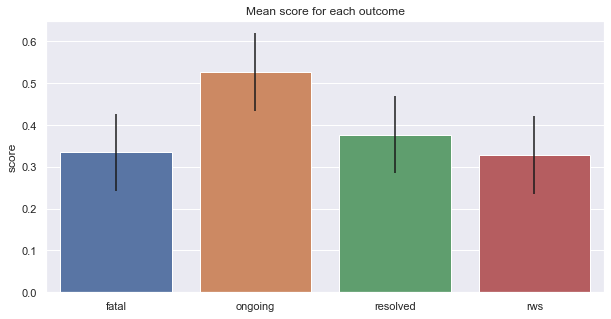

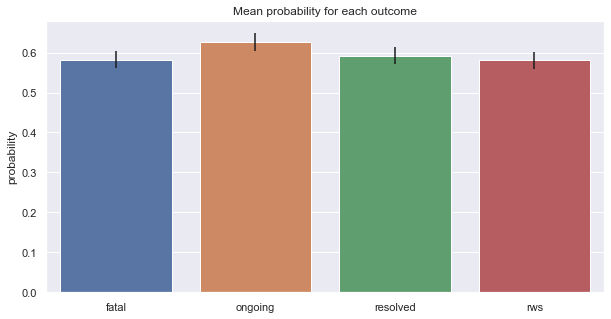

In [226]:
import matplotlib as plt
import seaborn as sns

# split dataframe into 4 dataframes based on outcome
results = {}
for outcome in outcomes:
    df_outcome = df_ranking.loc[df_ranking['statement'].str.contains(outcome)]
    # reset index
    df_outcome = df_outcome.reset_index(drop=True)
    print(df_outcome.head(10))
    
    # get mean value of score and prob
    mean_score = df_outcome['score'].mean()
    mean_prob = df_outcome['prob'].mean()
    
    # only select last part of word (after last /) in outcome
    outcome = (outcome.split('/')[-1]).lower()
    if outcome == "resolved_with_sequelae":
        outcome = "rws"
    results[outcome] = {'score': mean_score, 'probability': mean_prob}
    

# create barplot of mean score and mean prob for each outcome
# df_results = pd.DataFrame.from_dict(results, orient='index')
# plt.pyplot.figure(figsize=(10, 5))
# df_results.plot.bar(rot=0)
# plt.pyplot.title('Mean score and mean probability for each outcome')
# plt.pyplot.show()

# create barplot of mean score and mean prob for each outcome with seaborn
df_results = pd.DataFrame.from_dict(results, orient='index')

plt.pyplot.figure(figsize=(10, 5))
plt.pyplot.title('Mean score for each outcome')

# plot error bars
sns.barplot(x=df_results.index, y=df_results['score'], yerr=df_results['score'].std())


plt.pyplot.figure(figsize=(10, 5))
plt.pyplot.title('Mean probability for each outcome')
sns.barplot(x=df_results.index, y=df_results['probability'], yerr=df_results['probability'].std())


In [ ]:
# save model in AmpliGraph/tutorials/embeddings
create_tensorboard_visualizations(model, './embeddings')